In [1]:
%reload_ext autoreload
%autoreload 2

from dotenv import load_dotenv
import os
import pandas as pd


import os
from acled_conflict_analysis import processing
from acled_conflict_analysis import extraction
from acled_conflict_analysis import visuals
from datetime import datetime
# Import the OAuth authentication function
from acled_conflict_analysis.acled_auth import *

# Load environment variables
load_dotenv()

# Get Mapbox basemap URL from environment
MAPBOX_BASEMAP_URL = os.getenv('MAPBOX_BASEMAP_URL', '')

# Analysing Spatial Distribution of Conflict before and after the fall of the Assad Regime

In [120]:
COUNTRIES_OF_INTEREST = ["Syria"]

TODAY_DATE = datetime.today().date().isoformat()

START_DATE = "2023-11-23"
END_DATE = TODAY_DATE

In [121]:
# ============================
# LOAD AND PREPROCESS DATA
# ============================
# Load environment variables from .env file
# to ensure we can access API keys
load_dotenv()

# Extract the data
# Test single call to check for duplicate prints
print("🧪 Testing acled_api function for duplicate prints...")

data = extraction.acled_api(
    #email = acled_email,
    #password = acled_password,
    country_codes=COUNTRIES_OF_INTEREST,
    start_date=START_DATE,
    end_date=END_DATE  # Small date range for quick test
)
# Perfom data conversion
processing.data_type_conversion(data)

🧪 Testing acled_api function for duplicate prints...
🔄 Using cached OAuth token
URL: https://acleddata.com/api/acled/read
Parameters: {'_format': 'json', 'limit': 4000000, 'iso': '760', 'event_date': '2023-11-23|2026-02-02', 'event_date_where': 'BETWEEN', 'population': 'full', 'fields': 'region|country|iso|year|event_date|source|admin1|admin2|admin3|location|event_type|sub_event_type|interaction|fatalities|timestamp|latitude|longitude|actor1|actor2|notes|population_1km|population_5km|population_2km|population_best'}
✅ Successfully retrieved 28959 records


In [122]:
data["nrEvents"] = 1
data = data[data['event_type']!='Strategic developments']

In [123]:
def get_conflict_category(date):
    if date <= pd.Timestamp("2024-11-27") and date >= pd.Timestamp("2023-11-26"):
        return "Before Regime Change"
    elif date >= pd.Timestamp("2024-12-08") and date <= pd.Timestamp("2025-12-09"):
        return "After Regime Change"

In [124]:
data.loc[:, "category"] = data["event_date"].apply(get_conflict_category)
extracted_date = datetime.today().date().isoformat()
extracted_date_formatted = datetime.today().strftime('%B %d, %Y')

In [125]:
data.to_csv(f'../../data/conflict/raw_acled_{extracted_date}.csv')
data = pd.read_csv(f"../../data/conflict/raw_acled_{extracted_date}.csv")
processing.data_type_conversion(data)

In [126]:
conflict_daily = processing.get_acled_by_group(
    data, columns=["latitude", "longitude", "category"], freq="D"
)

In [127]:
daily_mean = (
    conflict_daily.groupby(["category", "latitude", "longitude"])[
        ["nrEvents", "nrFatalities"]
    ]
    .mean()
    .reset_index()
)
daily_median = (
    conflict_daily.groupby(["category", "latitude", "longitude"])[
        ["nrEvents", "nrFatalities"]
    ]
    .median()
    .reset_index()
)

In [128]:
daily_mean = processing.convert_to_gdf(daily_mean)
daily_median = processing.convert_to_gdf(daily_median)

In [129]:
import geopandas as gpd

syria_adm1 = gpd.read_file("../../data/boundaries/syr_admin1.shp")
syria_adm0 = gpd.read_file("../../data/boundaries/syr_admin0.shp")

### Mean Conflict Index

The conflict intensity index is calculated as the geometric mean of conflict events and fatalities, with an adjustment to handle zero values:

$$\text{Conflict Intensity Index} = \sqrt{(\text{nrEvents}) \times (\text{nrFatalities} + 1)}$$

Where:
- $\text{nrEvents}$ is the number of conflict events in a given period and location
- $\text{nrFatalities}$ is the number of fatalities from conflicts in the same period and location
- The addition of 1 to each term ensures the index is defined even when either component is zero. This is arbitrary and is doen just to account for 0 values of fatalities and conflicts. 

This index provides a balanced measure that accounts for both the frequency of conflicts and their severity.  Compared to arithmetic means, the geometric mean reduces the influence of extreme values in either component (conflict events + fatalities). Areas with both high events and high fatalities will have higher index values than areas with many events but few fatalities or vice versa.

Conflict index is calculated at the location and then average is taken over time (across the three time periods). This is to preserve the integrity of the conflict index in that specific location. 

In [130]:
import numpy as np
conflict_daily["conflict_intensity_index_op1"] = np.sqrt(
    (conflict_daily["nrEvents"]) * (conflict_daily["nrFatalities"] + 1)
)

In [131]:
daily_conflict_intensity = (
    conflict_daily.groupby(["category", "latitude", "longitude"])[
        ["nrEvents", "nrFatalities", "conflict_intensity_index_op1"]
    ]
    .mean()
    .reset_index()
)
daily_conflict_intensity = processing.convert_to_gdf(daily_conflict_intensity)

In [132]:
syria_adm0 = gpd.read_file("../../data/boundaries/syr_admin0.shp")

## Hexagonal Aggregation
Below are maps where the fatalities and conflict events are aggregated to hexagons of size 276 sq km each. This shows greater variance spatially.

In [133]:
syria_h3 = processing.convert_to_h3_grid(syria_adm0, resolution=5)

In [134]:
data["event_date"] = pd.to_datetime(data["event_date"])

In [135]:
conflict_daily_h3 = processing.get_acled_by_admin(
    syria_h3, data, columns=["h3_index", "category"], freq="D"
)
conflict_daily_h3.drop(columns=["index"], inplace=True)

conflict_daily_h3["conflict_intensity_index_op1"] = np.sqrt(
    (conflict_daily_h3["nrEvents"]) * (conflict_daily_h3["nrFatalities"] + 1)
)

# calculating average 'daily' conflict index
conflict_daily_h3_mean = (
    conflict_daily_h3.groupby(["h3_index", "category"])[
        ["nrEvents", "nrFatalities", "conflict_intensity_index_op1"]
    ]
    .mean()
    .reset_index()
)

conflict_daily_h3_mean = syria_h3.merge(
    conflict_daily_h3_mean, on="h3_index", how="left"
)

In [136]:
conflict_category_h3 = processing.get_acled_by_admin(
    syria_h3, data, columns=["h3_index", "category"], freq="D"
)
conflict_category_h3.drop(columns=["index"], inplace=True)

conflict_category_h3 = conflict_category_h3.groupby(['h3_index', 'category'])[['nrEvents', 'nrFatalities']].sum().reset_index()

conflict_category_h3['conflict_intensity_index'] = np.sqrt( conflict_category_h3["nrEvents"]) * (conflict_category_h3["nrFatalities"] + 1)

conflict_category_h3 = syria_h3.merge(
    conflict_category_h3, on="h3_index", how="left"
)

### Spatial Distribution of Average Daily Conflict

In [137]:
category_list = ['Before Regime Change', 'After Regime Change']

/Users/ssarva/syria-economic-monitor/.venv/lib/python3.13/site-packages/IPython/core/events.py:82: UserWarning: Glyph 8594 (\N{RIGHTWARDS ARROW}) missing from font(s) Open Sans.
  func(*args, **kwargs)


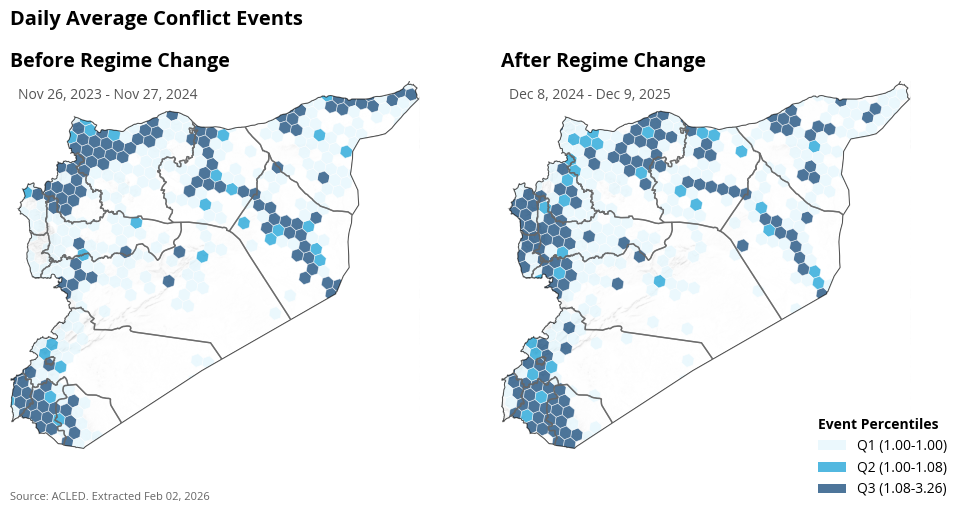

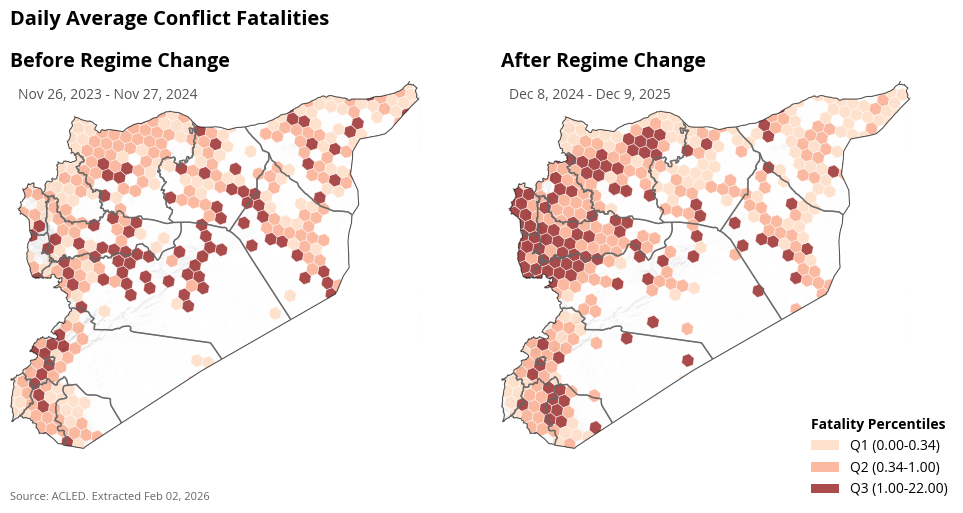

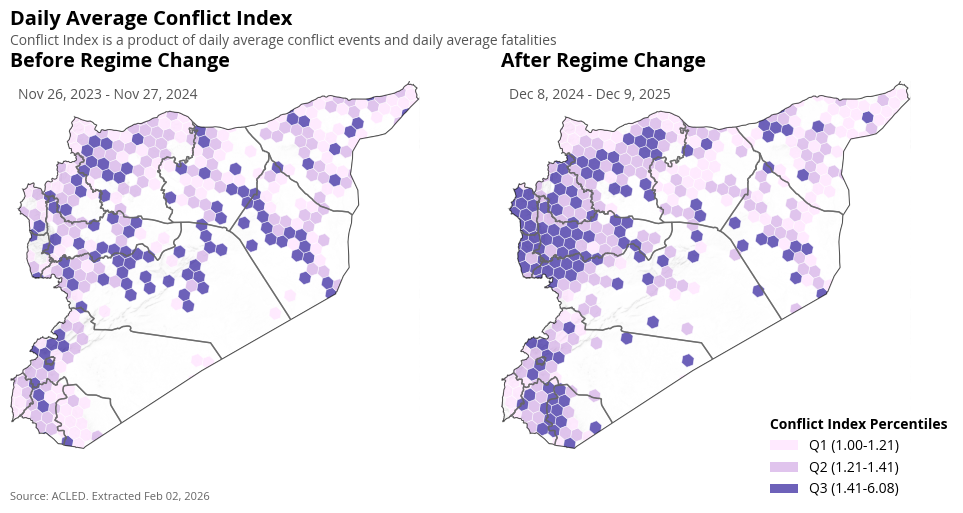

/Users/ssarva/syria-economic-monitor/.venv/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 8594 (\N{RIGHTWARDS ARROW}) missing from font(s) Open Sans.
  fig.canvas.print_figure(bytes_io, **kw)


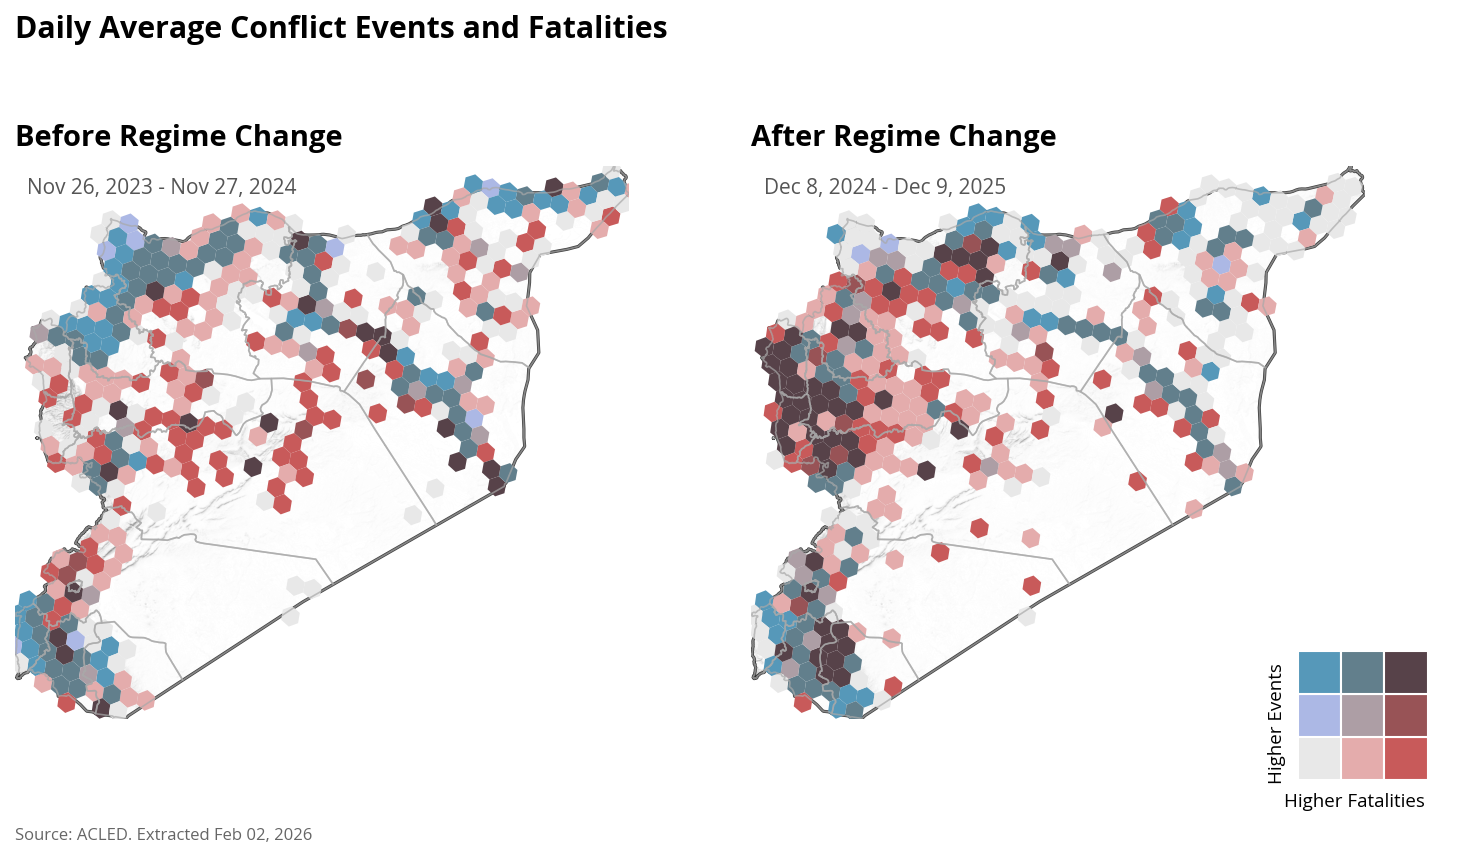

In [138]:
fig, ax = visuals.get_h3_maps(
    conflict_daily_h3_mean, 
    'Daily Average Conflict Events', 
    measure='nrEvents',
    category_list=category_list,
    custom_colors=["#E3F6FD",
    "#089BD4",
    "#023B6F"],
    country_boundary=syria_adm0,
    admin1_boundary=syria_adm1,
    basemap_choice=MAPBOX_BASEMAP_URL,
    basemap_alpha=0.5,
        date_ranges={
        'Before Regime Change': 'Nov 26, 2023 - Nov 27, 2024',
        'After Regime Change': 'Dec 8, 2024 - Dec 9, 2025'
    },
    legend_title='Event Percentiles'
)

fig, ax = visuals.get_h3_maps(
    conflict_daily_h3_mean, 
    'Daily Average Conflict Fatalities', 
    measure='nrFatalities',
    category_list=category_list,
    custom_colors=['#ffd6b9', '#f99c78',  '#870000'],
    country_boundary=syria_adm0,
    admin1_boundary=syria_adm1,
    basemap_choice=MAPBOX_BASEMAP_URL,
    basemap_alpha=0.5,
    date_ranges={
        'Before Regime Change': 'Nov 26, 2023 - Nov 27, 2024',
        'After Regime Change': 'Dec 8, 2024 - Dec 9, 2025'
    },
    legend_title='Fatality Percentiles'
)

fig, ax = visuals.get_h3_maps(
    conflict_daily_h3_mean, 
    title = 'Daily Average Conflict Index', 
    subtitle='Conflict Index is a product of daily average conflict events and daily average fatalities',
    measure='conflict_intensity_index_op1',
    category_list=category_list,
    custom_colors=['#FFE2FF',
'#D3ACE6',
'#2F1E9C'],
    country_boundary=syria_adm0,
    admin1_boundary=syria_adm1,
    basemap_choice=MAPBOX_BASEMAP_URL,
    basemap_alpha=0.5,
    date_ranges={
        'Before Regime Change': 'Nov 26, 2023 - Nov 27, 2024',
        'After Regime Change': 'Dec 8, 2024 - Dec 9, 2025'
    },
    legend_title='Conflict Index Percentiles'
)

fig, ax = visuals.create_bivariate_map_with_basemap(
    conflict_data=conflict_daily_h3_mean,
    category_list=category_list,
    country_boundary=syria_adm0,
    admin1_boundary=syria_adm1,
    main_title="Daily Average Conflict Events and Fatalities",
    basemap_choice=MAPBOX_BASEMAP_URL,
    basemap_alpha=1,
    hexagon_alpha=1,
    date_ranges={
        'Before Regime Change': 'Nov 26, 2023 - Nov 27, 2024',
        'After Regime Change': 'Dec 8, 2024 - Dec 9, 2025'
    }
)

The average conflict events and conflict fatalities per day has increased in the Lattakia,  of the country after regime change. In some parts around Damascus the conflicts reduced, while they increased in others. 

In [139]:
conflict_pc_diff_h3 = conflict_daily_h3_mean.copy()
conflict_pc_diff_h3['conflict_intensity_index_op1'] = conflict_pc_diff_h3['conflict_intensity_index_op1'].fillna(0)
conflict_pc_diff_h3 = conflict_pc_diff_h3.pivot_table(index='h3_index', columns='category', values='conflict_intensity_index_op1', aggfunc='mean').reset_index()
conflict_pc_diff_h3['pc_change'] = 100*(conflict_pc_diff_h3['After Regime Change'] - conflict_pc_diff_h3['Before Regime Change']) / (conflict_pc_diff_h3['Before Regime Change'])

# Melt to get categories as rows
conflict_pc_diff_melted = conflict_pc_diff_h3.melt(
    id_vars=['h3_index', 'pc_change'], 
    value_vars=['Before Regime Change', 'After Regime Change'],
    var_name='category', 
    value_name='conflict_intensity_index_op1'
)
conflict_pc_diff_melted = conflict_pc_diff_melted[conflict_pc_diff_melted['category']=='After Regime Change']

conflict_pc_diff_melted = syria_h3.merge(conflict_pc_diff_melted, on='h3_index', how='left')

In [2]:
areas_of_control = pd.read_excel('../../data/boundaries/Copy of 2026.02.01_TCC_AoC.xlsx')
areas_of_control.rename(columns={'Longitude': 'longitude', 'Latitude': 'latitude'}, inplace=True)

In [3]:
areas_of_control = processing.convert_to_gdf(areas_of_control)

In [4]:
# Convert datetime column names to date strings
areas_of_control.columns = [
    col.strftime('%Y-%m-%d') if isinstance(col, datetime) 
    else col 
    for col in areas_of_control.columns
]

list(areas_of_control.columns)

['Index',
 'Location Name (en)',
 'Location Name (ar)',
 'Community code (pcode)',
 'ADM1: Governorate / Mohafaza (en)',
 'ADM1: Governorate / Mohafaza (ar)',
 'ADM2: District / Mantiqa (en)',
 'ADM2: District / Mantiqa (ar)',
 'ADM3: Sub-District / Nahia (en)',
 'ADM3: Sub-District / Nahia (ar)',
 'ADM4: City / Town / Community (en)',
 'ADM4: City / Town / Community (ar)',
 'ADM5: Neighborhood (en)',
 'ADM5: Neighborhood (ar)',
 'ADM6: Point Of Interest (en)',
 'ADM6: Point Of Interest (ar)',
 'latitude',
 'longitude',
 '2014-01-01',
 '2014-06-01',
 '2015-01-01',
 '2015-02-01',
 '2015-03-01',
 '2015-04-01',
 '2015-05-01',
 '2015-06-01',
 '2015-07-01',
 '2015-08-01',
 '2015-09-01',
 '2015-10-01',
 '2015-11-01',
 '2015-12-01',
 '2016-01-01',
 '2016-02-01',
 '2016-03-01',
 '2016-04-01',
 '2016-05-01',
 '2016-06-01',
 '2016-07-01',
 '2016-08-01',
 '2016-09-01',
 '2016-10-01',
 '2016-11-01',
 '2016-12-01',
 '2017-01-01',
 '2017-02-01',
 '2017-03-01',
 '2017-04-01',
 '2017-05-01',
 '2017-06

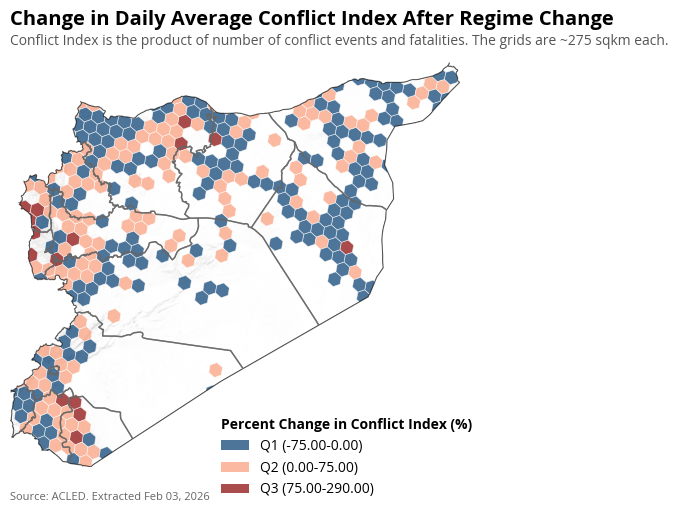

In [233]:
# Example 3: Custom bin edges for classification
# Define fixed bins: 0-5 events (low), 5-15 events (medium), 15+ events (high)
custom_bin_edges = [-75, 0, 75, 290]

fig, ax = visuals.get_h3_maps(
    conflict_pc_diff_melted, 
    'Change in Daily Average Conflict Index After Regime Change', 
    subtitle='Conflict Index is the product of number of conflict events and fatalities. The grids are ~275 sqkm each.',
    measure='pc_change',
    category_list=['After Regime Change'],
    custom_colors=[ "#023B6F", '#f99c78',  '#870000'],
    country_boundary=syria_adm0,
    admin1_boundary=syria_adm1,
    basemap_choice=MAPBOX_BASEMAP_URL,
    basemap_alpha=0.5,
    custom_bins=custom_bin_edges,  # Custom classification bins
    subplot_titles=[],  # List of titles
    # date_ranges={
    #     'Before Regime Change': 'Nov 26, 2023 - Nov 27, 2024',
    #     'After Regime Change': 'Dec 8, 2024 - Dec 9, 2025'
    # },
    legend_title='Percent Change in Conflict Index (%)',
    #basemap_choice=MAPBOX_BASEMAP_URL
)

In [145]:
conflict_type = processing.get_acled_by_admin(
    syria_h3, data, columns=["h3_index", "category", "event_type", 'sub_event_type'], freq="D"
)
conflict_type.drop(columns=["index"], inplace=True)

# calculating average 'daily' conflict index
conflict_type = (
    conflict_type.groupby([ "category", 'event_type', 'sub_event_type'])[
        ["nrEvents", "nrFatalities"]
    ]
    .sum()
    .reset_index()
)


## Major Conflict Types

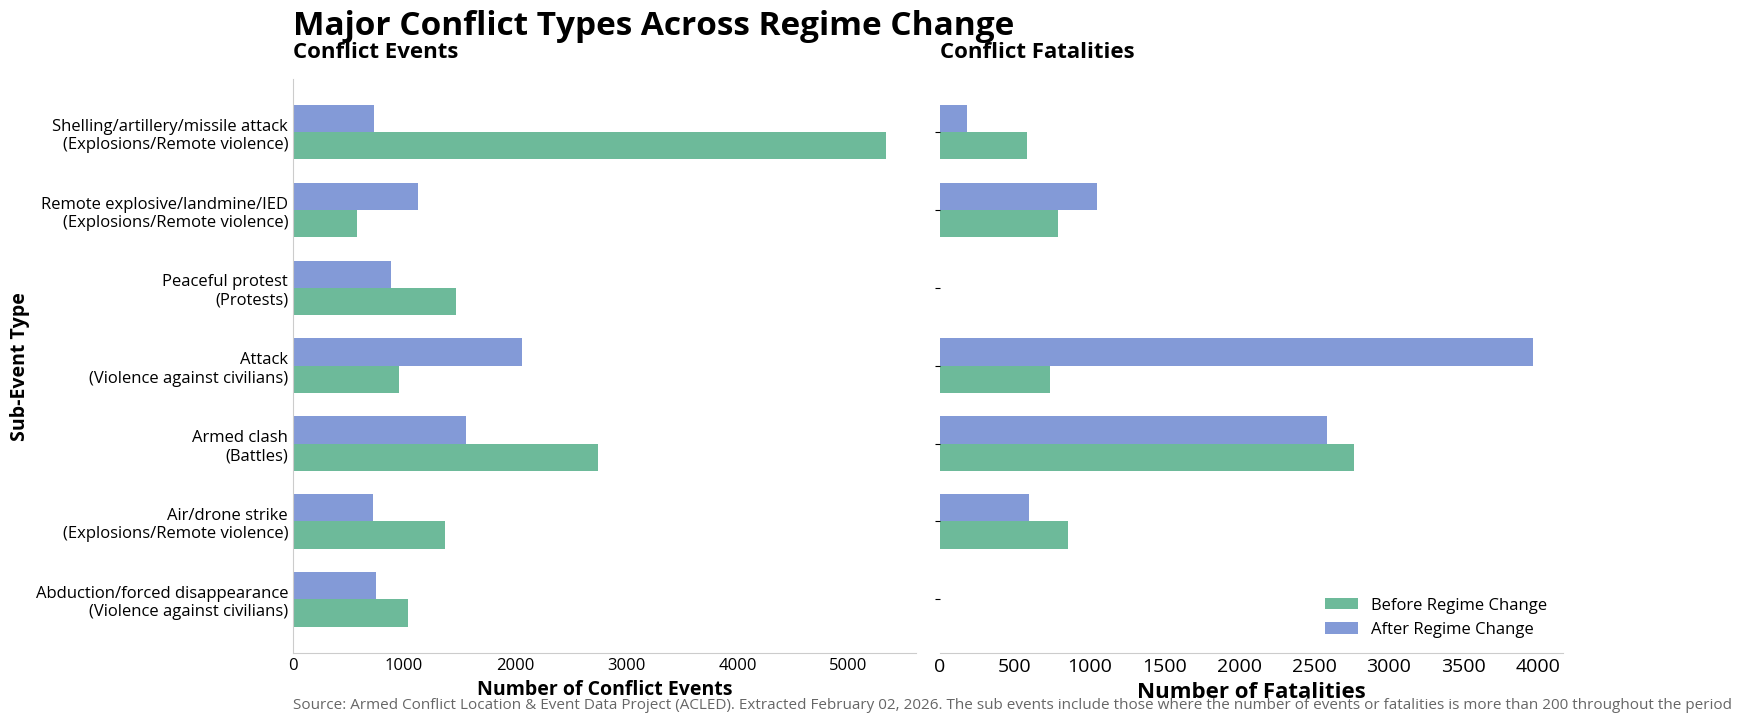

In [146]:
import matplotlib.pyplot as plt
from matplotlib import font_manager

# Set Open Sans font
plt.rcParams['font.family'] = 'Open Sans'

# Filter out sub_event_types with less than 50 events or fatalities
conflict_type_filtered = conflict_type.groupby(['sub_event_type', 'category']).filter(
    lambda x: (x['nrEvents'].sum() >= 200) or (x['nrFatalities'].sum() >= 200)
)

# Create a mapping of sub_event_type to event_type
sub_to_event_map = conflict_type_filtered.groupby('sub_event_type')['event_type'].first().to_dict()

# Pivot the data for both events and fatalities
conflict_pivot_events = conflict_type_filtered.pivot_table(
    index='sub_event_type', 
    columns='category', 
    values='nrEvents', 
    aggfunc='sum',
    fill_value=0
)

conflict_pivot_fatalities = conflict_type_filtered.pivot_table(
    index='sub_event_type', 
    columns='category', 
    values='nrFatalities', 
    aggfunc='sum',
    fill_value=0
)

# Create labels with event_type in brackets
labels_with_event_type = [f"{sub_event}\n({sub_to_event_map[sub_event]})" 
                          for sub_event in conflict_pivot_events.index]

# Create side-by-side horizontal bar charts
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 7), sharey=True)

# Set colors
color_before = '#54AE89'
color_after = '#6D88D1'
spine_color = '#CCCCCC'

# Set the bar height and positions
y = range(len(conflict_pivot_events.index))
height = 0.35

# Plot 1: Events
ax1.barh([i - height/2 for i in y], conflict_pivot_events['Before Regime Change'], 
         height, label='Before Regime Change', color=color_before, alpha=0.85)
ax1.barh([i + height/2 for i in y], conflict_pivot_events['After Regime Change'], 
         height, label='After Regime Change', color=color_after, alpha=0.85)

ax1.set_xlabel('Number of Conflict Events', fontsize=14, fontweight='bold', fontfamily='Open Sans')
ax1.set_ylabel('Sub-Event Type', fontsize=14, fontweight='bold', fontfamily='Open Sans')
ax1.set_title('Conflict Events', fontsize=16, fontweight='bold', pad=15, fontfamily='Open Sans', loc='left')
ax1.set_yticks(y)
ax1.set_yticklabels(labels_with_event_type, fontfamily='Open Sans', fontsize=14)
ax1.tick_params(axis='x', labelsize=12, length=0)
ax1.tick_params(axis='y', labelsize=12, length=0)
for label in ax1.get_yticklabels():
    label.set_fontfamily('Open Sans')
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.spines['left'].set_color(spine_color)
ax1.spines['bottom'].set_color(spine_color)
ax1.grid(False)

# Plot 2: Fatalities
ax2.barh([i - height/2 for i in y], conflict_pivot_fatalities['Before Regime Change'], 
         height, label='Before Regime Change', color=color_before, alpha=0.85)
ax2.barh([i + height/2 for i in y], conflict_pivot_fatalities['After Regime Change'], 
         height, label='After Regime Change', color=color_after, alpha=0.85)

ax2.set_xlabel('Number of Fatalities', fontsize=16, fontweight='bold', fontfamily='Open Sans')
ax2.set_title('Conflict Fatalities', fontsize=16, fontweight='bold', pad=15, fontfamily='Open Sans', loc='left')
ax2.tick_params(axis='x', labelsize=14, length=0)
for label in ax2.get_xticklabels():
    label.set_fontfamily('Open Sans')
ax2.legend(loc='lower right', frameon=False, prop={'family': 'Open Sans', 'size': 12})
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.spines['left'].set_visible(False)
ax2.spines['bottom'].set_color(spine_color)
ax2.grid(False)

# Add main title
fig.suptitle('Major Conflict Types Across Regime Change', fontsize=24, fontweight='bold', 
             fontfamily='Open Sans', x=0.08, ha='left', y=0.999)

# Add source at the bottom left
fig.text(0.08, 0.001, f'Source: Armed Conflict Location & Event Data Project (ACLED). Extracted {extracted_date_formatted}. The sub events include those where the number of events or fatalities is more than 200 throughout the period', 
         ha='left', fontsize=11, fontfamily='Open Sans', style='italic', color='#666666')

plt.tight_layout()
plt.subplots_adjust(top=0.90, bottom=0.08, left=0.08)
plt.show()


## Major Conflict Topics

This section uses natural language processing to identify distinct protest topics/themes:

**Method**: TF-IDF (Term Frequency-Inverse Document Frequency) with K-means clustering identifies groups of conflict events that share similar language and themes.

**Process**:
1. **Text Preprocessing**: Apply word normalization and custom stopwords to clean the data
2. **TF-IDF Vectorization**: Convert text to numerical features, weighting words by their importance


**Time Period Analysis**: We run this analysis separately for before and after regime change

In [245]:
# import pandas as pd
# import numpy as np
# from acled_conflict_analysis.text_analysis import (
#     plot_wordcloud_comparison,
#     get_word_counts,
#     get_ngram_counts,
#     get_tfidf_word_frequencies,
#     custom_stopwords
# )

# # Auto-reload modules when they change
# %load_ext autoreload
# %autoreload 2

In [246]:
before_regime = data[data['category']=='Before Regime Change']
after_regime = data[data['category']=='After Regime Change']

In [247]:
additional_stopwords = [
    'fatality', 'fatalities',
    'casualty', 'casualties', 
    'injury', 'injuries',
    'unknown', 'countryside', 'regime',
    'syria', 'clash', 'man', 'fighter', 'killed', 'killing'
]
custom_stopwords = custom_stopwords + additional_stopwords

NameError: name 'custom_stopwords' is not defined

In [248]:
word_counts_before_regime = get_word_counts(
    before_regime, 
    column_name='notes', 
    custom_stopwords=custom_stopwords
)

word_counts_after_regime = get_word_counts(
    after_regime, 
    column_name='notes', 
    custom_stopwords=custom_stopwords
)

In [249]:
from acled_conflict_analysis.text_analysis import get_tfidf_word_frequencies

word_normalizations = {
    'moroccan': 'morocco',
    'moroccans': 'morocco',
    'palestinian': 'palestine',
    'palestinians': 'palestine',
    'israeli': 'israel',
    'israelis': 'israel',
    'egyptian': 'egypt',
    'egyptians': 'egypt',
    'iraqi': 'iraq',
    'iraqis': 'iraq',
    'syrian': 'syria',
    'syrians': 'syria',
    'lebanese': 'lebanon',
    'yemeni': 'yemen',
    'yemenis': 'yemen',
    'salaries': 'salary',
    'retirees': 'retirement',
    'retired': 'retirement',
}

# Add normalized forms to stopwords to ensure they're removed after normalization
normalized_stopwords = custom_stopwords + list(set(word_normalizations.values()))

tfidf_before_regime = get_tfidf_word_frequencies(
    df=before_regime,
    text_column='notes',
    custom_stopwords=normalized_stopwords,
    word_normalizations=word_normalizations,
    top_n=100
)

tfidf_after_regime = get_tfidf_word_frequencies(
    df=after_regime,
    text_column='notes',
    custom_stopwords=normalized_stopwords,
    word_normalizations=word_normalizations,
    top_n=100
)

# Manually filter out stopwords from results (in case normalization happened after initial filtering)
stopwords_set = set(normalized_stopwords)
tfidf_before_regime = {k: v for k, v in tfidf_before_regime.items() if k not in stopwords_set}
tfidf_after_regime = {k: v for k, v in tfidf_after_regime.items() if k not in stopwords_set}

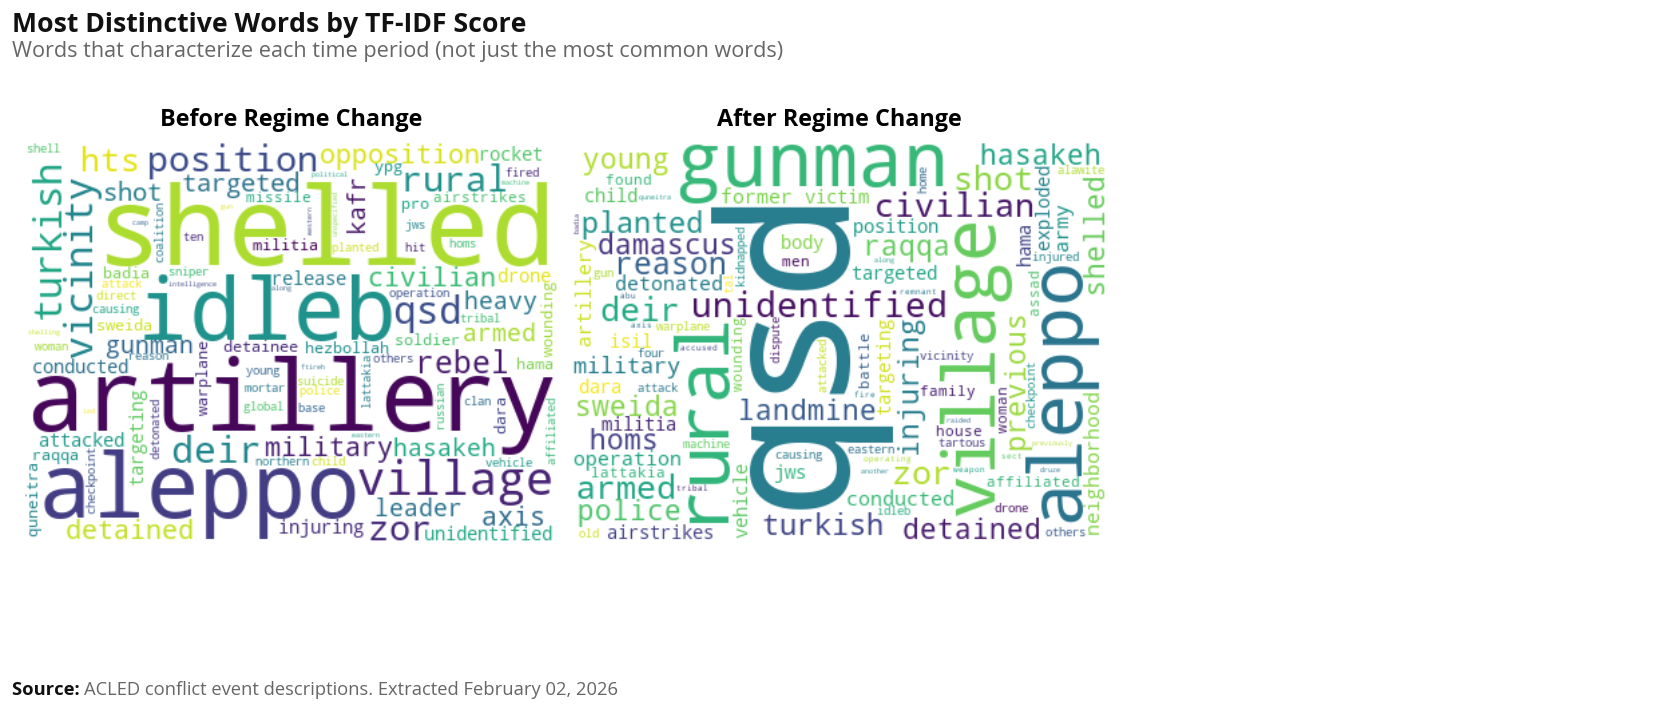

In [250]:
plot_wordcloud_comparison(
    word_freq_dicts=[tfidf_before_regime, tfidf_after_regime],
    subplot_titles=['Before Regime Change', 'After Regime Change'],
    main_title='Most Distinctive Words by TF-IDF Score',
    subtitle='Words that characterize each time period (not just the most common words)',
    note=f'ACLED conflict event descriptions. Extracted {extracted_date_formatted}',
    figsize=(14, 6),
    ncols=3
)

## Syrian Areas of Control

In [24]:
areas_of_control['2026-02-01'] = areas_of_control['2026-02-01'].replace({'US And NSAGs': 'US and NSAGs'})

In [25]:
from scipy.spatial import Voronoi
from shapely.geometry import Polygon
import numpy as np
import geopandas as gpd

# Load Syria boundary
syria_boundary = gpd.read_file("../../data/boundaries/syr_admin0.shp")

# Get point coordinates
coords = np.array([[point.x, point.y] for point in areas_of_control.geometry])

# Create Voronoi diagram
vor = Voronoi(coords)

# Function to create finite polygons from Voronoi regions
def voronoi_finite_polygons(vor, radius=None):
    """Reconstruct infinite voronoi regions to finite regions."""
    if vor.points.shape[1] != 2:
        raise ValueError("Requires 2D input")
    
    new_regions = []
    new_vertices = vor.vertices.tolist()
    
    center = vor.points.mean(axis=0)
    if radius is None:
        radius = np.ptp(vor.points, axis=0).max() * 2
    
    # Construct a map containing all ridges for a given point
    all_ridges = {}
    for (p1, p2), (v1, v2) in zip(vor.ridge_points, vor.ridge_vertices):
        all_ridges.setdefault(p1, []).append((p2, v1, v2))
        all_ridges.setdefault(p2, []).append((p1, v1, v2))
    
    # Reconstruct infinite regions
    for p1, region in enumerate(vor.point_region):
        vertices = vor.regions[region]
        
        if all(v >= 0 for v in vertices):
            # finite region
            new_regions.append(vertices)
            continue
        
        # reconstruct a non-finite region
        ridges = all_ridges[p1]
        new_region = [v for v in vertices if v >= 0]
        
        for p2, v1, v2 in ridges:
            if v2 < 0:
                v1, v2 = v2, v1
            if v1 >= 0:
                # finite ridge: already in the region
                continue
            
            # Compute the missing endpoint of an infinite ridge
            t = vor.points[p2] - vor.points[p1]
            t /= np.linalg.norm(t)
            n = np.array([-t[1], t[0]])
            
            midpoint = vor.points[[p1, p2]].mean(axis=0)
            direction = np.sign(np.dot(midpoint - center, n)) * n
            far_point = vor.vertices[v2] + direction * radius
            
            new_region.append(len(new_vertices))
            new_vertices.append(far_point.tolist())
        
        # sort region counterclockwise
        vs = np.asarray([new_vertices[v] for v in new_region])
        c = vs.mean(axis=0)
        angles = np.arctan2(vs[:, 1] - c[1], vs[:, 0] - c[0])
        new_region = np.array(new_region)[np.argsort(angles)]
        
        new_regions.append(new_region.tolist())
    
    return new_regions, np.asarray(new_vertices)

# Get finite Voronoi regions
regions, vertices = voronoi_finite_polygons(vor)

# Create polygons for each point and clip to Syria boundary
control_polygons = []
control_values = []

for i, region in enumerate(regions):
    polygon_coords = vertices[region]
    polygon = Polygon(polygon_coords)
    
    # Clip to Syria boundary
    clipped = polygon.intersection(syria_boundary.union_all())
    
    # Only keep valid polygons
    if not clipped.is_empty and clipped.area > 0:
        control_polygons.append(clipped)
        control_values.append(areas_of_control.iloc[i]['2026-02-01'])

# Create new GeoDataFrame with polygons
areas_of_control_polygons = gpd.GeoDataFrame({
    '2026-02-01': control_values,
    'geometry': control_polygons
}, crs=areas_of_control.crs)

print(f"Created {len(areas_of_control_polygons)} polygons from {len(areas_of_control)} points")
print(f"Polygons per control type:")
print(areas_of_control_polygons['2026-02-01'].value_counts())

areas_of_control_polygons

Created 8096 polygons from 8099 points
Polygons per control type:
2026-02-01
Syrian Transitional Government    6977
SDF                                980
Druze Armed Groups                 112
Israel                              21
US and NSAGs                         6
Name: count, dtype: int64


,2026-02-01,geometry
0,SDF,"POLYGON ((38.35331 36.89698, 38.35301 36.89955..."
1,Syrian Transitional Government,"POLYGON ((36.98597 36.64472, 36.98547 36.64575..."
2,SDF,"POLYGON ((38.12831 36.80263, 38.14096 36.80762..."
3,SDF,"POLYGON ((38.14096 36.80762, 38.14249 36.8323,..."
4,SDF,"POLYGON ((38.34613 36.89093, 38.352 36.89246, ..."
...,...,...
8091,Syrian Transitional Government,"POLYGON ((40.28531 36.69198, 40.29548 36.69473..."
8092,Syrian Transitional Government,"POLYGON ((40.2055 36.85658, 40.19984 36.85523,..."
8093,Syrian Transitional Government,"POLYGON ((40.25772 36.90717, 40.28219 36.8763,..."
8094,Syrian Transitional Government,"POLYGON ((40.00612 36.71534, 40.01413 36.7268,..."


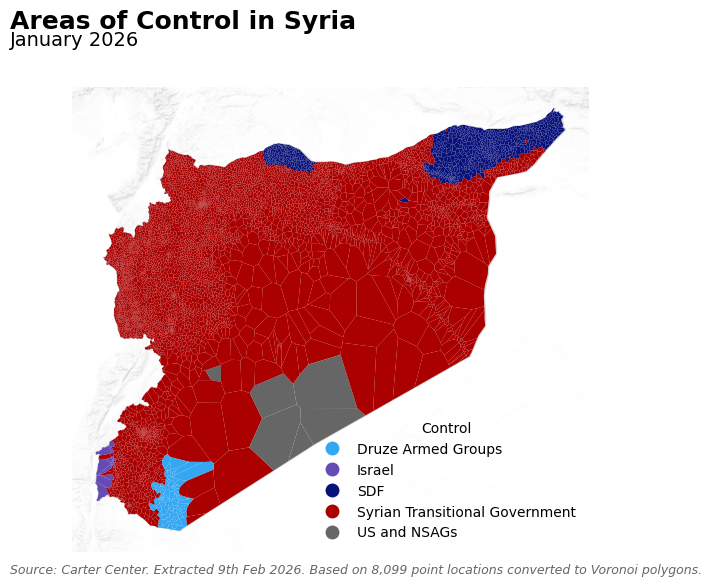

In [26]:
import matplotlib.pyplot as plt
import contextily as ctx
from matplotlib.colors import ListedColormap

# World Bank categorical colors
wb_colors = ['#34A7F2', '#FF9800', '#664AB6', '#4EC2C0', '#F3578E', 
             '#081079', '#0C7C68', '#AA0000', '#DDDA21', '#666666']

# Create figure
fig, ax = plt.subplots(figsize=(8, 6))

# Plot the areas of control with legend
gdf_plot = areas_of_control_polygons.to_crs(epsg=3857)
gdf_plot.plot(
    column='2026-02-01',
    ax=ax,
    legend=True,
    categorical=True,
    cmap=ListedColormap(wb_colors),
    alpha=1.0,
    edgecolor='none',
    linewidth=0,
    legend_kwds={'loc': 'lower right', 'frameon': False, 'title': 'Control', 'fontsize': 10}
)

# Add basemap
ctx.add_basemap(
    ax,
    source=MAPBOX_BASEMAP_URL,
    alpha=0.3,
    zoom='auto',
    zorder=0
)

# Remove axes
ax.set_axis_off()

# Add title and subtitle
fig.suptitle('Areas of Control in Syria', fontsize=18, fontweight='bold', x=0.10, ha='left', y=0.96)
fig.text(0.10, 0.90, 'January 2026', fontsize=14, ha='left')

# Add source note
fig.text(0.10, 0.02, f'Source: Carter Center. Extracted 9th Feb 2026. Based on 8,099 point locations converted to Voronoi polygons.', 
         fontsize=9, ha='left', style='italic', color='#666666')

plt.tight_layout(rect=[0, 0.03, 1, 0.92])
plt.show()

In [19]:
# Check available date columns in areas_of_control
date_columns = [col for col in areas_of_control.columns if col not in ['latitude', 'longitude', 'geometry']]
print(f"Available date columns: {date_columns}")
print(f"\nTotal columns: {len(date_columns)}")

Available date columns: ['Index', 'Location Name (en)', 'Location Name (ar)', 'Community code (pcode)', 'ADM1: Governorate / Mohafaza (en)', 'ADM1: Governorate / Mohafaza (ar)', 'ADM2: District / Mantiqa (en)', 'ADM2: District / Mantiqa (ar)', 'ADM3: Sub-District / Nahia (en)', 'ADM3: Sub-District / Nahia (ar)', 'ADM4: City / Town / Community (en)', 'ADM4: City / Town / Community (ar)', 'ADM5: Neighborhood (en)', 'ADM5: Neighborhood (ar)', 'ADM6: Point Of Interest (en)', 'ADM6: Point Of Interest (ar)', '2014-01-01', '2014-06-01', '2015-01-01', '2015-02-01', '2015-03-01', '2015-04-01', '2015-05-01', '2015-06-01', '2015-07-01', '2015-08-01', '2015-09-01', '2015-10-01', '2015-11-01', '2015-12-01', '2016-01-01', '2016-02-01', '2016-03-01', '2016-04-01', '2016-05-01', '2016-06-01', '2016-07-01', '2016-08-01', '2016-09-01', '2016-10-01', '2016-11-01', '2016-12-01', '2017-01-01', '2017-02-01', '2017-03-01', '2017-04-01', '2017-05-01', '2017-06-01', '2017-07-01', '2017-08-01', '2017-09-01', '2

In [21]:
# Create Voronoi polygons for each year from 2014 to 2026
from scipy.spatial import Voronoi
from shapely.geometry import Polygon
import numpy as np

# Years to process
years = range(2014, 2027)  # 2014 to 2026 inclusive
date_columns_yearly = [f"{year}-02-01" for year in years]

# Load Syria boundary
syria_boundary = gpd.read_file("../../data/boundaries/syr_admin0.shp")

# Function to create finite polygons from Voronoi regions
def voronoi_finite_polygons(vor, radius=None):
    """Reconstruct infinite voronoi regions to finite regions."""
    if vor.points.shape[1] != 2:
        raise ValueError("Requires 2D input")
    
    new_regions = []
    new_vertices = vor.vertices.tolist()
    
    center = vor.points.mean(axis=0)
    if radius is None:
        radius = np.ptp(vor.points, axis=0).max() * 2
    
    # Construct a map containing all ridges for a given point
    all_ridges = {}
    for (p1, p2), (v1, v2) in zip(vor.ridge_points, vor.ridge_vertices):
        all_ridges.setdefault(p1, []).append((p2, v1, v2))
        all_ridges.setdefault(p2, []).append((p1, v1, v2))
    
    # Reconstruct infinite regions
    for p1, region in enumerate(vor.point_region):
        vertices = vor.regions[region]
        
        if all(v >= 0 for v in vertices):
            # finite region
            new_regions.append(vertices)
            continue
        
        # reconstruct a non-finite region
        ridges = all_ridges[p1]
        new_region = [v for v in vertices if v >= 0]
        
        for p2, v1, v2 in ridges:
            if v2 < 0:
                v1, v2 = v2, v1
            if v1 >= 0:
                # finite ridge: already in the region
                continue
            
            # Compute the missing endpoint of an infinite ridge
            t = vor.points[p2] - vor.points[p1]
            t /= np.linalg.norm(t)
            n = np.array([-t[1], t[0]])
            
            midpoint = vor.points[[p1, p2]].mean(axis=0)
            direction = np.sign(np.dot(midpoint - center, n)) * n
            far_point = vor.vertices[v2] + direction * radius
            
            new_region.append(len(new_vertices))
            new_vertices.append(far_point.tolist())
        
        # sort region counterclockwise
        vs = np.asarray([new_vertices[v] for v in new_region])
        c = vs.mean(axis=0)
        angles = np.arctan2(vs[:, 1] - c[1], vs[:, 0] - c[0])
        new_region = np.array(new_region)[np.argsort(angles)]
        
        new_regions.append(new_region.tolist())
    
    return new_regions, np.asarray(new_vertices)

# Get point coordinates (same for all years)
coords = np.array([[point.x, point.y] for point in areas_of_control.geometry])

# Create Voronoi diagram (same for all years)
vor = Voronoi(coords)

# Get finite Voronoi regions
regions, vertices = voronoi_finite_polygons(vor)

# Dictionary to store GeoDataFrames for each year
yearly_polygons = {}

for date_col in date_columns_yearly:
    if date_col in areas_of_control.columns:
        print(f"Processing {date_col}...")
        
        # Create polygons for each point and clip to Syria boundary
        control_polygons = []
        control_values = []
        
        for i, region in enumerate(regions):
            polygon_coords = vertices[region]
            polygon = Polygon(polygon_coords)
            
            # Clip to Syria boundary
            clipped = polygon.intersection(syria_boundary.union_all())
            
            # Only keep valid polygons
            if not clipped.is_empty and clipped.area > 0:
                control_polygons.append(clipped)
                control_values.append(areas_of_control.iloc[i][date_col])
        
        # Create GeoDataFrame for this year
        yearly_polygons[date_col] = gpd.GeoDataFrame({
            'control': control_values,
            'geometry': control_polygons
        }, crs=areas_of_control.crs)
        
        print(f"  Created {len(yearly_polygons[date_col])} polygons")

print(f"\nTotal years processed: {len(yearly_polygons)}")

Processing 2015-02-01...
  Created 8096 polygons
Processing 2016-02-01...
  Created 8096 polygons
Processing 2017-02-01...
  Created 8096 polygons
Processing 2018-02-01...
  Created 8096 polygons
Processing 2019-02-01...
  Created 8096 polygons
Processing 2020-02-01...
  Created 8096 polygons
Processing 2021-02-01...
  Created 8096 polygons
Processing 2022-02-01...
  Created 8096 polygons
Processing 2023-02-01...
  Created 8096 polygons
Processing 2024-02-01...
  Created 8096 polygons
Processing 2025-02-01...
  Created 8096 polygons
Processing 2026-02-01...
  Created 8096 polygons

Total years processed: 12


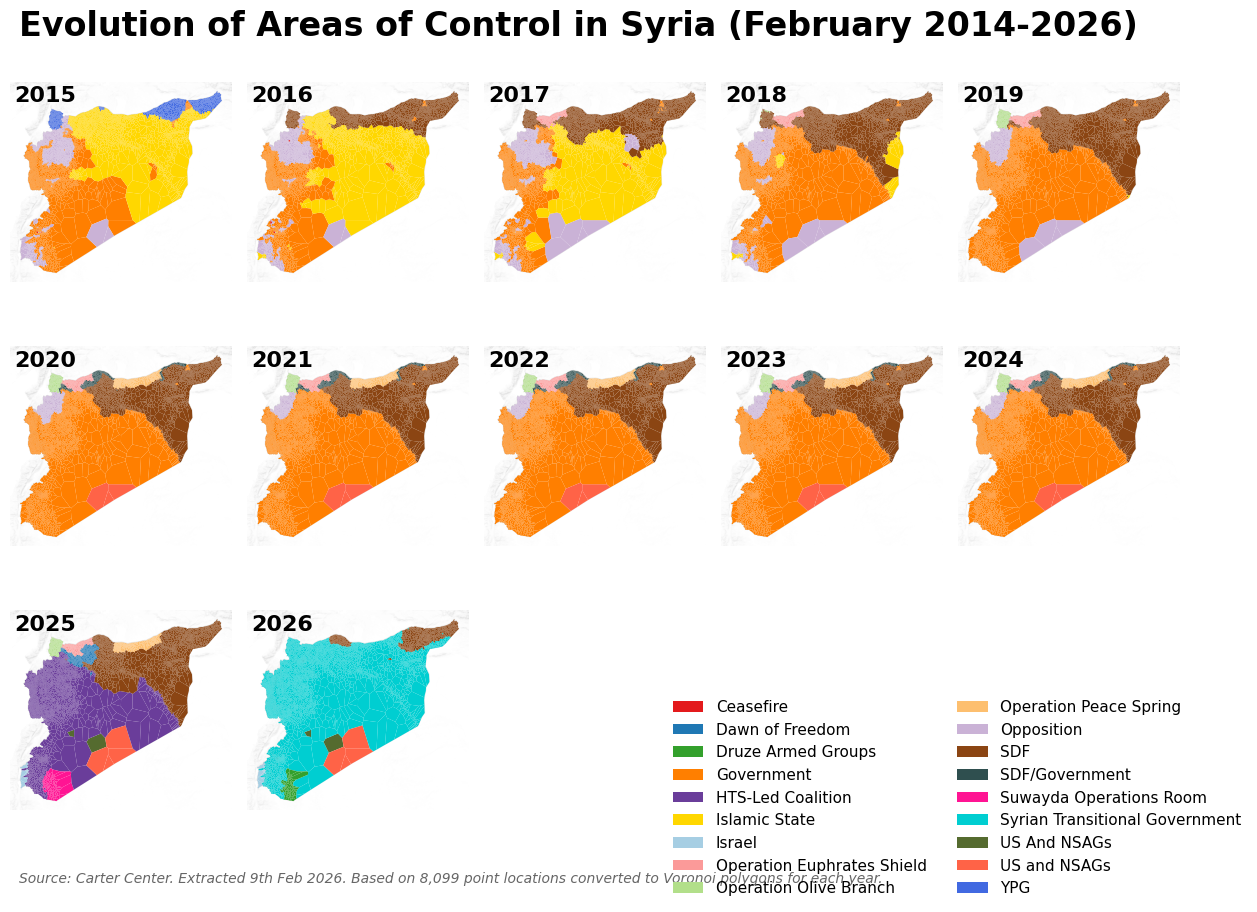

In [23]:
import matplotlib.pyplot as plt
import contextily as ctx
from matplotlib.colors import ListedColormap

# Very distinct colors for each control group - maximally different hues
unique_colors = [
    '#E31A1C',  # Bright Red
    '#1F78B4',  # Deep Blue
    '#33A02C',  # Green
    '#FF7F00',  # Orange
    '#6A3D9A',  # Purple
    '#FFD700',  # Gold
    '#A6CEE3',  # Light Blue
    '#FB9A99',  # Pink
    '#B2DF8A',  # Light Green
    '#FDBF6F',  # Light Orange
    '#CAB2D6',  # Light Purple
    '#8B4513',  # Brown
    '#2F4F4F',  # Dark Slate Gray
    '#FF1493',  # Deep Pink
    '#00CED1',  # Dark Turquoise
    '#556B2F',  # Dark Olive Green
    '#FF6347',  # Tomato
    '#4169E1',  # Royal Blue
    '#8B008B',  # Dark Magenta
    '#DC143C'   # Crimson
]

# Create subplots - 3 rows x 5 columns (13 years + 2 empty)
fig, axes = plt.subplots(3, 5, figsize=(12, 9))
axes = axes.flatten()

# Get all unique control types across all years
all_controls = sorted(set([val for gdf in yearly_polygons.values() 
                           for val in gdf['control'].dropna().unique()]))

# Create a consistent color mapping for all years
control_to_color = {control: unique_colors[i % len(unique_colors)] 
                    for i, control in enumerate(all_controls)}

# Plot each year
for idx, (date_col, gdf) in enumerate(yearly_polygons.items()):
    ax = axes[idx]
    
    # Convert to Web Mercator for basemap
    gdf_plot = gdf.to_crs(epsg=3857)
    
    # Map control types to colors
    gdf_plot['color'] = gdf_plot['control'].map(control_to_color)
    
    # Plot polygons
    gdf_plot.plot(
        color=gdf_plot['color'],
        ax=ax,
        alpha=1.0,
        edgecolor='none',
        linewidth=0
    )
    
    # Add basemap
    ctx.add_basemap(
        ax,
        source=MAPBOX_BASEMAP_URL,
        alpha=0.3,
        zoom='auto',
        zorder=0
    )
    
    # Remove axes
    ax.set_axis_off()
    
    # Add year as title (left aligned)
    year = date_col.split('-')[0]
    ax.text(0.02, 0.98, f'{year}', 
            transform=ax.transAxes,
            fontsize=16, 
            fontweight='bold',
            verticalalignment='top',
            horizontalalignment='left')

# Hide unused subplots
for idx in range(len(yearly_polygons), len(axes)):
    axes[idx].set_visible(False)

# Add main title (left aligned)
fig.text(0.02, 0.98, 'Evolution of Areas of Control in Syria (February 2014-2026)', 
         fontsize=24, fontweight='bold', ha='left', va='top')

# Create custom legend
from matplotlib.patches import Patch
legend_elements = [Patch(facecolor=control_to_color[control], label=control) 
                   for control in all_controls]

# Add legend below the plots
fig.legend(handles=legend_elements, 
          loc='lower right', 
          ncol=2,
          frameon=False,
          fontsize=11,
          bbox_to_anchor=(1.05, -0.02))

# Add source note (left aligned)
fig.text(0.02, 0.01, 
         f'Source: Carter Center. Extracted 9th Feb 2026. Based on 8,099 point locations converted to Voronoi polygons for each year.', 
         ha='left', fontsize=10, style='italic', color='#666666')

plt.tight_layout(rect=[0, 0.03, 1, 0.96])
plt.show()